# Лабораторная работа 6
## Начально-краевые задачи для дифференциального уравнения гиперболического типа

Моисеенков И.П., М8О-408Б-19

### Задание
Используя явную схему крест и неявную схему, решить начально-краевую задачу для дифференциального уравнения гиперболического типа. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением U(x, t).

Вариант 3.

$\large\frac{\partial^2 u}{\partial t^2} = \frac{\partial^2 u}{\partial x^2} - 3u$

$u(0, t) = sin(2t)$

$u(\pi, t) = -sin(2t)$

$u(x, 0) = 0$

$u_t(x, 0) = 2cos(x)$

Аналитическое решение: $U(x, t) = cos(x)sin(2t)$

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
x_begin = 0
x_end = math.pi

t_begin = 0
t_end = 5

h = 0.01
sigma = 1

Начальные условия:

In [ ]:
# boundary conditions
def phi_0(t):
    return math.sin(2*t)

def phi_1(t):
    return -math.sin(2*t)

# initial conditions
def psi_0(x):
    return 0

def psi_1(x):
    return 2 * math.cos(x)

def solution(x, t):
    return math.cos(x) * math.sin(2*t)

## Аналитическое решение

Подготовим ответ, полученный аналитическим способом. С ним будем сравнивать численные методы

In [ ]:
def get_analytical_solution(
    x_range, # (x_begin, x_end)
    t_range, # (t_begin, t_end)
    h, # len of cell by x
    sigma=sigma, # coefficient sigma
):
    """
    Get analytical solution of hyperbolic DE
    Returns matrix U with values of function
    """
    tau = np.sqrt(sigma * h**2) # len of cell by t
    x = np.arange(*x_range, h)
    t = np.arange(*t_range, tau)

    res = np.zeros((len(t), len(x)))
    for idx in range(len(x)):
        for idt in range(len(t)):
            res[idt][idx] = solution(x[idx], t[idt])
    
    return res

In [ ]:
analytical_solution = get_analytical_solution(
    x_range=(x_begin, x_end),
    t_range=(t_begin, t_end),
    h=h,
    sigma=sigma,
)

Будем складывать все решения в словарь, чтобы потом удобнее было строить графики

In [ ]:
solutions = dict()
solutions["analytical solution"] = analytical_solution

Функция для вычисления погрешности - максимального модуля ошибки

In [ ]:
def max_abs_error(A, B):
    """
    Calculate max absolute error of elements of matrices A and B
    """
    assert A.shape == B.shape
    return abs(A - B).max()

И среднего модуля ошибки:

In [ ]:
def mean_abs_error(A, B):
    """
    Calculate mean absolute error of elements of matrices A and B
    """
    assert A.shape == B.shape
    return abs(A - B).mean()

Функция для построения результата - функций U(x), полученных разыми методами, при заданном времени t.

In [ ]:
def plot_results(
    solutions, # dict: solutions[method name] = solution
    time, # moment of time
    x_range, # (x_begin, x_end)
    t_range, # (t_begin, t_end)
    h, # len of cell by x
    sigma, # coefficient sigma
):
    tau = np.sqrt(sigma * h**2) # len of cell by t
    x = np.arange(*x_range, h)
    times = np.arange(*t_range, tau)
    cur_t_id = abs(times - time).argmin()

    plt.figure(figsize=(15, 9))
    for method_name, solution in solutions.items():
        plt.plot(x, solution[cur_t_id], label=method_name)

    plt.legend()
    plt.grid()
    plt.show()

Зависимость погрешности от времени

In [ ]:
def plot_errors_from_time(
    solutions, # dict: solutions[method name] = solution
    analytical_solution_name, # for comparing
    t_range, # (t_begin, t_end)
    h, # len of cell by x
    sigma, # coefficient sigma
):
    """
    Plot max_abs_error = f(time)
    """
    tau = np.sqrt(sigma * h**2) # len of cell by t
    t = np.arange(*t_range, tau)

    plt.figure(figsize=(15, 9))
    for method_name, solution in solutions.items():
        if method_name == analytical_solution_name:
            continue
        max_abs_errors = np.array([
            max_abs_error(solution[i], solutions[analytical_solution_name][i])
            for i in range(len(t))
        ])
        plt.plot(t, max_abs_errors, label=method_name)

    plt.xlabel('time')
    plt.ylabel('Max abs error')

    plt.legend()
    plt.grid()
    plt.show()

### Явная конечно-разностная схема

В исходном уравнении перейдем от производных к их численным приближениям. Вторую производную будем аппроксимировать по значениям нижнего временного слоя.

Получим рекуррентное соотношение:

$\large u_j^{k+1} = \sigma(u_{j+1}^k-2u_j^k+u_{j-1}^k) + (2 - 3\tau^2)u_j^k - u_j^{k-1}$


где $\large\sigma = \frac{\tau^2}{h^2}$.

Для нижнего временного ряда:

$u_j^0 = \psi_1(x_j)$

$u_j^1 = \psi_1(x_j) + \psi_2(x_j)\tau$

Остальные значения $u$ в нижнем временном ряду известны из начальных условий. Далее можем в цикле проходиться по сетке и рекурретно считать значения в ней по полученной формуле.

*Примечание: можно было повысить порядок аппроксимации для $u_j^1$, но т.к. в моем случае $\psi_1 = 0$, то и вторая производная от нее будет равна нулю, а следовательно повышение порядка бессмысленно*

In [ ]:
def explicit_finite_difference_method(
    x_range, # (x_begin, x_end)
    t_range, # (t_begin, t_end)
    h, # len of cell by x
    sigma, # coefficient sigma
    phi_0=phi_0, # boundary condition 0
    phi_1=phi_1, # boundary condition 1
    psi_0=psi_0, # initial condition 0,
    psi_1=psi_1, # initial condition 1 (first derivative),
):
    """
    Solves hyperbolic DE using explicit schema of finite difference method.
    Returns matrix U with values of function
    """
    tau = np.sqrt(sigma * h**2) # len of cell by t
    x = np.arange(*x_range, h)
    t = np.arange(*t_range, tau)

    res = np.zeros((len(t), len(x)))
    # row 0 -> use initial condition 0
    for col_id in range(len(x)):
        res[0][col_id] = psi_0(x[col_id])
    
    # row 1 -> use approximation
    for col_id in range(len(x)):
        res[1][col_id] = psi_0(x[col_id]) + tau * psi_1(x[col_id])

    for row_id in range(2, len(t)):
        # col 0 -> use boundary condition 0
        res[row_id][0] = phi_0(t[row_id])
        # cols 1..n-1 -> use explicit schema
        for col_id in range(1, len(x)-1):
            res[row_id][col_id] = (
                sigma * (
                    res[row_id-1][col_id+1] 
                    - 2 * res[row_id-1][col_id]
                    + res[row_id-1][col_id-1]
                )
                + (2 - 3 * tau**2) * res[row_id-1][col_id]
                - res[row_id-2][col_id]
            )
        # col n -> use boundary condition 1
        res[row_id][-1] = phi_1(t[row_id])
    return res

In [ ]:
explicit_solution = explicit_finite_difference_method(
    x_range=(x_begin, x_end),
    t_range=(t_begin, t_end),
    h=h,
    sigma=sigma,
)

In [ ]:
solutions["explicit schema"] = explicit_solution

Погрешность в сравнении с аналитическим решением:

In [ ]:
print(f'max abs error = {max_abs_error(explicit_solution, analytical_solution)}')
print(f'mean abs error = {mean_abs_error(explicit_solution, analytical_solution)}')

max abs error = 0.00010771631567718654
mean abs error = 2.9333840606808786e-05


Явная схема устойчива при условии $\sigma = \frac{\tau^2}{h^2} < 1$

### Неявная конечно-разностная схема

В исходном уравнении перейдем от производных к их численным приближениям. Вторую производную будем аппроксимировать по значениям верхнего временного слоя.

Чтобы получить значения $u$ в одном временном ряду, необходимо решить систему уравнений:

$\large\begin{equation*}
 \begin{cases}
   b_1u_1^{k+1}+c_1u_2^{k+1}=d_1, ~~~j=1, 
   \\
   a_ju_{j-1}^{k+1}+b_ju_j^{k+1}+c_ju_{j+1}^{k+1}=d_j, ~~~j=2\dots N-2,
   \\
   a_{N-1}u_{N-2}^{k+1}+b_{N-1}u_{N-1}^{k+1}=d_{N-1}, ~~~j=N-1.
 \end{cases}
\end{equation*}$

$a_j=c_j=\sigma$

$b_j=-(1 + 2\sigma + 3\tau^2)$

$d_j = -2u_j^k + u_j^{k-1}, ~~~j=2\dots N-2$

$d_1=-(u_1^k+\sigma\phi_0(t^{k+1}))$

$d_{N-1}=-(u_{N-1}^k+\sigma\phi_1(t^{k+1}))$


Это трехдиагональная СЛАУ, которую можно решить методом прогонки.

In [ ]:
# stolen from lab 1-2
def tridiagonal_solve(A, b):
    """
    Solves Ax=b, where A - tridiagonal matrix
    Returns x
    """
    n = len(A)
    # Step 1. Forward
    v = [0 for _ in range(n)]
    u = [0 for _ in range(n)]
    v[0] = A[0][1] / -A[0][0]
    u[0] = b[0] / A[0][0]
    for i in range(1, n-1):
        v[i] = A[i][i+1] / (-A[i][i] - A[i][i-1] * v[i-1])
        u[i] = (A[i][i-1] * u[i-1] - b[i]) / (-A[i][i] - A[i][i-1] * v[i-1])
    v[n-1] = 0
    u[n-1] = (A[n-1][n-2] * u[n-2] - b[n-1]) / (-A[n-1][n-1] - A[n-1][n-2] * v[n-2])

    # Step 2. Backward
    x = [0 for _ in range(n)]
    x[n-1] = u[n-1]
    for i in range(n-1, 0, -1):
        x[i-1] = v[i-1] * x[i] + u[i-1]
    return np.array(x)

In [ ]:
def implicit_finite_difference_method(
    x_range, # (x_begin, x_end)
    t_range, # (t_begin, t_end)
    h, # len of cell by x
    sigma, # coefficient sigma
    phi_0=phi_0, # boundary condition 0
    phi_1=phi_1, # boundary condition 1
    psi_0=psi_0, # initial condition 0,
    psi_1=psi_1, # initial condition 1 (first derivative),
):
    """
    Solves hyperbolic DE using implicit schema of finite difference method.
    Returns matrix U with values of function
    """
    tau = np.sqrt(sigma * h**2) # len of cell by t
    x = np.arange(*x_range, h)
    t = np.arange(*t_range, tau)
    res = np.zeros((len(t), len(x)))

    # row 0 -> use initial condition
    for col_id in range(len(x)):
        res[0][col_id] = psi_0(x[col_id])
    
    # row 1 -> use approximation
    for col_id in range(len(x)):
        res[1][col_id] = psi_0(x[col_id]) + tau * psi_1(x[col_id])

    for row_id in range(2, len(t)):
        A = np.zeros((len(x)-2, len(x)-2)) # first and last elements will be counted with boundary conditions

        # create system of equations for implicit schema
        A[0][0] = -(1 + 2*sigma + 3*tau**2)
        A[0][1] = sigma
        for i in range(1, len(A) - 1):
            A[i][i-1] = sigma
            A[i][i] = -(1 + 2*sigma + 3*tau**2)
            A[i][i+1] = sigma
        A[-1][-2] = sigma
        A[-1][-1] = -(1 + 2*sigma + 3*tau**2)

        # vector b is previous line except first and last elements
        b = -2 * res[row_id-1][1:-1] + res[row_id-2][1:-1]
        # apply boundary conditions
        b[0] -= sigma * phi_0(t[row_id])
        b[-1] -= sigma * phi_1(t[row_id])

        res[row_id][0] = phi_0(t[row_id])
        res[row_id][-1] = phi_1(t[row_id])
        res[row_id][1:-1] = tridiagonal_solve(A, b)

    return res

In [ ]:
implicit_solution = implicit_finite_difference_method(
    x_range=(x_begin, x_end),
    t_range=(t_begin, t_end),
    h=h,
    sigma=sigma,
)

In [ ]:
solutions["implicit schema"] = implicit_solution

Погрешность в сравнении с аналитическим решением:

In [ ]:
print(f'max abs error = {max_abs_error(implicit_solution, analytical_solution)}')
print(f'mean abs error = {mean_abs_error(implicit_solution, analytical_solution)}')

max abs error = 0.041387088530764636
mean abs error = 0.01164499263579912


## Визуализация

Посмотрим на полученные функции при некотором фиксированном моменте времени

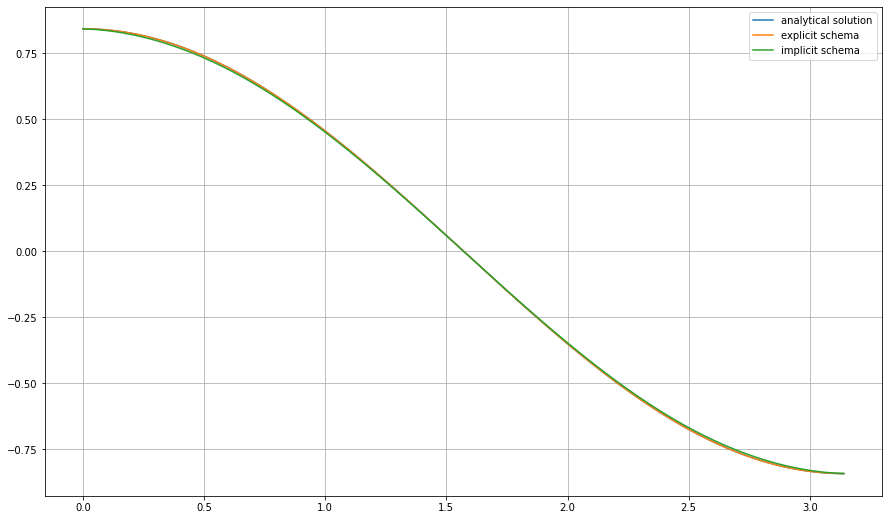

In [ ]:
plot_results(
    solutions=solutions,
    time=0.5,
    x_range=(x_begin, x_end),
    t_range=(t_begin, t_end),
    h=h,
    sigma=sigma,
)

Посмотрим, как меняется зависимость погрешности с течением времени

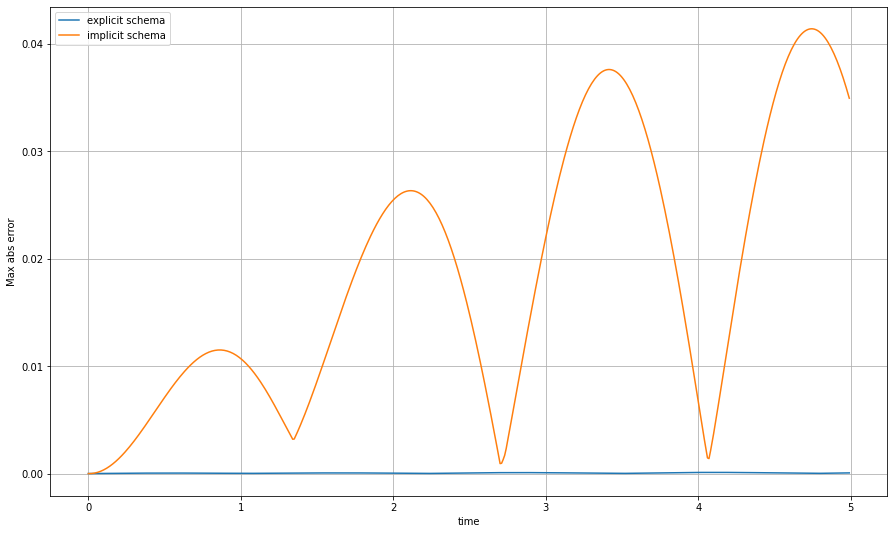

In [ ]:
plot_errors_from_time(
    solutions=solutions,
    analytical_solution_name="analytical solution",
    t_range=(t_begin, t_end),
    h=h,
    sigma=sigma,
)

Посмотрим отдельно на график для явной схемы

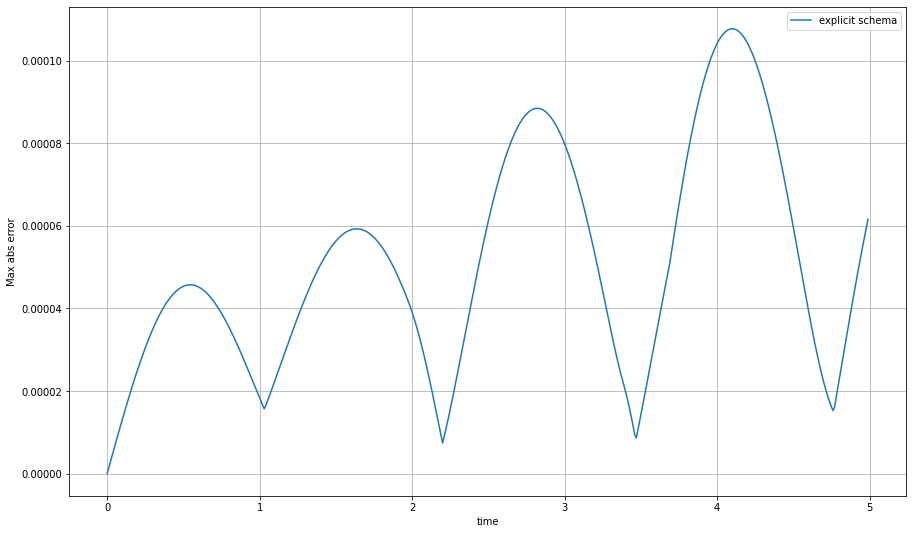

In [ ]:
tmp = dict()
tmp["analytical solution"] = solutions["analytical solution"]
tmp["explicit schema"] = solutions["explicit schema"]

plot_errors_from_time(
    solutions=tmp,
    analytical_solution_name="analytical solution",
    t_range=(t_begin, t_end),
    h=h,
    sigma=sigma,
)

## Вывод

В данной работе я научился решать начально-краевые задачи для ДУ гиперболического типа двумя способами:
* с помощью явной конечно-разностной схемы
* с помощью неявной конечно-разностной схемы

С помощью каждого метода получилось решить заданное ДУ с приемлемой точностью.

Явная конечно-разностная схема легко считается, но она условно устойчива, следовательно результат получится правдивый не при любых параметрах сетки.

Неявная конечно-разностная схема считается более сложным образом, но зато она абсолютно устойчива